###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1331)
random.seed(1331)

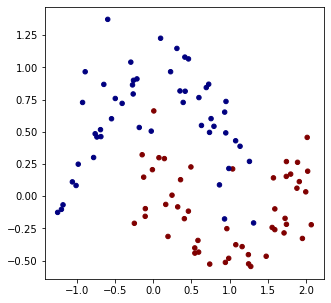

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.2)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
X

array([[ 0.59714612,  0.76566967],
       [ 1.87703816,  0.0622561 ],
       [-0.64484951,  0.86796587],
       [ 0.09656214,  1.22625623],
       [ 0.58443515, -0.3430811 ],
       [ 0.5443195 , -0.44155362],
       [ 0.54317221, -0.40128471],
       [ 1.99254918,  0.03397392],
       [ 1.07887515, -0.37638362],
       [ 2.06449957, -0.22130759],
       [-1.19863143, -0.10190721],
       [ 0.16394053, -0.06365801],
       [ 1.7089688 , -0.28494511],
       [-0.54445169,  0.60138944],
       [-0.75817244,  0.484777  ],
       [ 1.88516345,  0.26325004],
       [ 1.03768656,  0.21178854],
       [-0.97907626,  0.24868824],
       [ 0.59319436, -0.4336699 ],
       [ 0.98793027,  0.21530272],
       [ 0.31999323, -0.08267073],
       [ 1.25717565,  0.27019942],
       [ 0.98621602, -0.4820445 ],
       [ 0.94791235,  0.49164988],
       [ 0.34973442,  0.81712997],
       [-1.00740613,  0.08327993],
       [ 0.75563994,  0.6023425 ],
       [ 0.49272756,  0.22730521],
       [-0.77830477,

In [6]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
Xb, yb = X, y
inputs = [list(map(Value, xrow)) for xrow in Xb]
inputs

[[Value(data=0.5971461181223616, grad=0),
  Value(data=0.7656696720153715, grad=0)],
 [Value(data=1.8770381606532063, grad=0),
  Value(data=0.062256097164818, grad=0)],
 [Value(data=-0.6448495094182982, grad=0),
  Value(data=0.8679658654245872, grad=0)],
 [Value(data=0.09656213680396346, grad=0),
  Value(data=1.226256225220328, grad=0)],
 [Value(data=0.5844351452568994, grad=0),
  Value(data=-0.3430810980755112, grad=0)],
 [Value(data=0.5443195047121796, grad=0),
  Value(data=-0.44155362326917436, grad=0)],
 [Value(data=0.5431722127934653, grad=0),
  Value(data=-0.40128470808778044, grad=0)],
 [Value(data=1.9925491763179386, grad=0),
  Value(data=0.03397391801618137, grad=0)],
 [Value(data=1.0788751456386576, grad=0),
  Value(data=-0.37638362386499014, grad=0)],
 [Value(data=2.064499572222546, grad=0),
  Value(data=-0.22130758833882963, grad=0)],
 [Value(data=-1.1986314342243702, grad=0),
  Value(data=-0.10190721246733311, grad=0)],
 [Value(data=0.16394053265697112, grad=0),
  Value(da

In [7]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.7202288982713245, grad=0) 0.44


In [8]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 1.7202288982713245, accuracy 44.0%
step 1 loss 0.4952074232109, accuracy 77.0%
step 2 loss 0.38807663765854095, accuracy 84.0%
step 3 loss 0.6933758420657589, accuracy 80.0%
step 4 loss 0.6599933617522465, accuracy 74.0%
step 5 loss 0.6047139731593629, accuracy 79.0%
step 6 loss 0.34428230954137623, accuracy 87.0%
step 7 loss 0.2867062757891977, accuracy 87.0%
step 8 loss 0.26323387901632866, accuracy 89.0%
step 9 loss 0.27412794223378223, accuracy 91.0%
step 10 loss 0.2692040890415401, accuracy 87.0%
step 11 loss 0.316015152401433, accuracy 88.0%
step 12 loss 0.2348922781288798, accuracy 91.0%
step 13 loss 0.229965030829029, accuracy 92.0%
step 14 loss 0.2313751731650119, accuracy 90.0%
step 15 loss 0.2246163465075356, accuracy 92.0%
step 16 loss 0.21539221228641145, accuracy 92.0%
step 17 loss 0.21645416913222212, accuracy 93.0%
step 18 loss 0.22004373009930617, accuracy 92.0%
step 19 loss 0.25386601927651364, accuracy 90.0%
step 20 loss 0.21606481479334702, accuracy 92.0

(-1.54506482612706, 2.20493517387294)

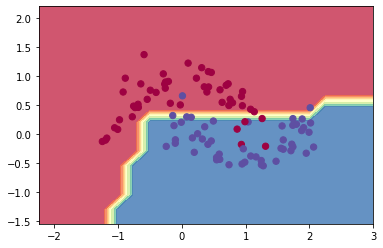

In [9]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


In [17]:
model([2,2])

Value(data=-11.877829513588951, grad=0)